<a href="https://colab.research.google.com/github/prasad26-cse/Stock-Market-Trend-Prediction1/blob/main/Stock_Market_Trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies if needed (uncomment in Colab)
# !pip install --quiet tensorflow==2.14.0 scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils
from google.colab import drive

In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# Mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Assignment/large_32 (2).csv"  # change if needed
DATE_COL = "Date Time"
OPEN_COL = "Open"
CLOSE_COL = "Close"
LOOKAHEAD = 5   # next 5 candles for label generation
WINDOW = 60     # number of past candles used as input sequence
TEST_SPLIT_RATIO = 0.15
VAL_SPLIT_RATIO = 0.1   # (of training set) used for validation during training
BATCH_SIZE = 64
EPOCHS = 60

In [ ]:
df = pd.read_csv(DATA_PATH)
print("Raw columns:", list(df.columns)[:40])
print("Rows:", len(df))

Raw columns: ['Date Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA 5', 'SMA 10', 'SMA 50', 'RSI 14', 'MACD LINE', 'MACD SIGNAL', 'MACD HISTOGRAM', 'BOLLINGER BAND SMA', 'BOLLINGER BAND UPPER', 'BOLLINGER BAND LOWER', 'ALLIGATOR JAW', 'ALLIGATOR TEETH', 'ALLIGATOR LIPS', 'EMA 9', 'KAMA', 'KAMA COLOR', 'ATR', 'RMA 14', 'SMOOTH MA 14', 'WMA 14']
Rows: 92514


In [ ]:
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df.sort_values(DATE_COL, inplace=True)
    df.reset_index(drop=True, inplace=True)
else:
    # If no Date Time column, assume already chronological
    print(f"Warning: '{DATE_COL}' not found; assuming rows are chronological.")

In [ ]:
original_df = df.copy()
# Ensure required columns exist
for col in [OPEN_COL, CLOSE_COL]:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not in CSV.")


In [ ]:
df = df.fillna(method="ffill").fillna(method="bfill")

/tmp/ipython-input-2389030365.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [ ]:
# 4) Label generation: next LOOKAHEAD candles
# For each row i, look at rows i+1 ... i+LOOKAHEAD (we will drop last LOOKAHEAD rows)
def generate_trend_label(sub):
    # sub is a DataFrame slice of length LOOKAHEAD
    opens = sub[OPEN_COL].values
    closes = sub[CLOSE_COL].values
    # all green?
    if np.all(closes > opens):
        return "uptrend"
    # all red?
    if np.all(closes < opens):
        return "downtrend"
    # else neutral
    return "neutral"

labels = []
for i in range(len(df) - LOOKAHEAD):
    window_next = df.iloc[i+1 : i+1+LOOKAHEAD]  # next LOOKAHEAD rows
    lab = generate_trend_label(window_next)
    labels.append(lab)

In [ ]:
# Trim df to match labels (remove last LOOKAHEAD rows)
df_labeled = df.iloc[: len(labels)].copy()
df_labeled["label"] = labels
print("Label distribution:\n", df_labeled["label"].value_counts())

Label distribution:
 label
neutral      87120
uptrend       2735
downtrend     2654
Name: count, dtype: int64


In [ ]:
# 5) Feature selection / engineering
# Choose features to feed the model. We'll use numeric columns except Date Time and label.
exclude = {DATE_COL, "label"}
feature_cols = [c for c in df_labeled.columns if c not in exclude and df_labeled[c].dtype in [np.float64, np.float32, np.int64, np.int32]]
print("Suggested numeric features (auto):", feature_cols)

# If you want top-of-file columns explicitly, you may choose:
# feature_cols = ["Open","High","Low","Close","Volume","SMA 5","SMA 10","RSI 14", ...]
# but we'll just use all numeric features found.

# Convert to numeric if necessary
df_feats = df_labeled[feature_cols].apply(pd.to_numeric, errors='coerce')
df_feats = df_feats.fillna(method="ffill").fillna(method="bfill")

Suggested numeric features (auto): ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA 5', 'SMA 10', 'SMA 50', 'RSI 14', 'MACD LINE', 'MACD SIGNAL', 'MACD HISTOGRAM', 'BOLLINGER BAND SMA', 'BOLLINGER BAND UPPER', 'BOLLINGER BAND LOWER', 'ALLIGATOR JAW', 'ALLIGATOR TEETH', 'ALLIGATOR LIPS', 'EMA 9', 'KAMA', 'KAMA COLOR', 'ATR', 'RMA 14', 'SMOOTH MA 14', 'WMA 14']


/tmp/ipython-input-2788248113.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feats = df_feats.fillna(method="ffill").fillna(method="bfill")


In [ ]:
# 7) Build sequences (X) and labels (y)
X = []
y = []
for i in range(WINDOW, len(df_feats)):
    seq = df_feats.iloc[i-WINDOW : i].values  # shape (WINDOW, n_features)
    X.append(seq)
    y.append(df_labeled["label"].iloc[i])    # label aligned with the last row of the window

X = np.array(X)  # shape (N, WINDOW, n_features)
y = np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (92449, 60, 25) y shape: (92449,)


In [ ]:
# 8) Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)   # integers 0..C-1
num_classes = len(le.classes_)
print("Classes:", le.classes_)


Classes: ['downtrend' 'neutral' 'uptrend']


In [ ]:
# 9) Train/validation/test split (time-series split — no shuffling)
n_total = len(X)
n_test = int(np.ceil(TEST_SPLIT_RATIO * n_total))
n_trainval = n_total - n_test

# For validation we'll carve out the last VAL_SPLIT_RATIO portion of the trainval part
n_val = int(np.ceil(VAL_SPLIT_RATIO * n_trainval))
n_train = n_trainval - n_val

X_train = X[:n_train]
y_train = y_enc[:n_train]
X_val = X[n_train:n_train+n_val]
y_val = y_enc[n_train:n_train+n_val]
X_test = X[n_train+n_val:]
y_test = y_enc[n_train+n_val:]

print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

Train / Val / Test sizes: 70722 7859 13868


In [ ]:
# 10) Fit scaler on flattened features of train data, then transform all splits
n_features = X.shape[2]
scaler = StandardScaler()
# Fit on train flattened (stack windows)
X_train_flat = X_train.reshape(-1, n_features)
scaler.fit(X_train_flat)

def scale_X(X_in):
    n = X_in.shape[0]
    return scaler.transform(X_in.reshape(-1, n_features)).reshape(n, WINDOW, n_features)

X_train_s = scale_X(X_train)
X_val_s = scale_X(X_val)
X_test_s = scale_X(X_test)


In [ ]:
# 11) Class weights to mitigate imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(12.361824855794442), 1: np.float64(0.3535923203839808), 2: np.float64(10.990209790209791)}


In [ ]:
# 12) Build model - LSTM classifier
def build_lstm_model(window=WINDOW, features=n_features, num_classes=num_classes):
    inp = layers.Input(shape=(window, features))
    x = layers.Masking()(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_lstm_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 25)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 60, 25)    │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 60, 25)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 60)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 60, 256)   │    157,696 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 256)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 330,499 (1.26 MB)

 Trainable params: 330,499 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 13) Callbacks
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
mc = callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)

In [ ]:
# # 14) Train
# history = model.fit(
#     X_train_s, y_train,
#     validation_data=(X_val_s, y_val),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     class_weight=class_weights_dict,
#     callbacks=[es, mc],
#     verbose=2
# #
# 14) Train
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[es, mc],
    verbose=2
)
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)
print("\n=== Training Details per Epoch ===")
print(history_df)

# Print last epoch summary
print("\n=== Final Epoch Results ===")
for k, v in history.history.items():
    print(f"{k}: {v[-1]:.4f}")

# Print best validation accuracy epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch}  |  Best Val Accuracy: {best_val_acc:.4f}")


Epoch 1/60


1106/1106 - 23s - 21ms/step - accuracy: 0.3269 - loss: 1.1100 - val_accuracy: 0.0407 - val_loss: 1.1262
Epoch 2/60


1106/1106 - 17s - 16ms/step - accuracy: 0.2528 - loss: 1.0978 - val_accuracy: 0.0412 - val_loss: 1.0751
Epoch 3/60
1106/1106 - 18s - 16ms/step - accuracy: 0.1873 - loss: 1.0965 - val_accuracy: 0.1316 - val_loss: 1.0948
Epoch 4/60


1106/1106 - 17s - 16ms/step - accuracy: 0.1879 - loss: 1.0941 - val_accuracy: 0.0978 - val_loss: 1.0639
Epoch 5/60


1106/1106 - 21s - 19ms/step - accuracy: 0.2195 - loss: 1.0926 - val_accuracy: 0.1006 - val_loss: 1.0637
Epoch 6/60
1106/1106 - 17s - 16ms/step - accuracy: 0.2024 - loss: 1.0905 - val_accuracy: 0.0602 - val_loss: 1.0896
Epoch 7/60
1106/1106 - 17s - 16ms/step - accuracy: 0.2209 - loss: 1.0901 - val_accuracy: 0.2022 - val_loss: 1.0660
Epoch 8/60
1106/1106 - 18s - 16ms/step - accuracy: 0.1722 - loss: 1.0894 - val_accuracy: 0.1000 - val_loss: 1.0843
Epoch 9/60
1106/1106 - 17s - 15ms/step - accuracy: 0.2360 - loss: 1.0860 - val_accuracy: 0.0687 - val_loss: 1.0779
Epoch 10/60
1106/1106 - 22s - 19ms/step - accuracy: 0.1126 - loss: 1.0860 - val_accuracy: 0.1313 - val_loss: 1.0875
Epoch 11/60
1106/1106 - 17s - 16ms/step - accuracy: 0.1664 - loss: 1.0833 - val_accuracy: 0.0639 - val_loss: 1.0903
Epoch 12/60
1106/1106 - 17s - 16ms/step - accuracy: 0.2250 - loss: 1.0831 - val_accuracy: 0.4559 - val_loss: 1.0711
Epoch 13/60


1106/1106 - 18s - 16ms/step - accuracy: 0.2605 - loss: 1.0785 - val_accuracy: 0.2488 - val_loss: 1.0365
Epoch 14/60
1106/1106 - 17s - 15ms/step - accuracy: 0.2445 - loss: 1.0798 - val_accuracy: 0.3938 - val_loss: 1.0630
Epoch 15/60
1106/1106 - 17s - 15ms/step - accuracy: 0.2431 - loss: 1.0759 - val_accuracy: 0.2205 - val_loss: 1.0904
Epoch 16/60
1106/1106 - 18s - 16ms/step - accuracy: 0.1778 - loss: 1.0731 - val_accuracy: 0.1444 - val_loss: 1.0940
Epoch 17/60
1106/1106 - 17s - 15ms/step - accuracy: 0.1961 - loss: 1.0698 - val_accuracy: 0.3478 - val_loss: 1.0614
Epoch 18/60
1106/1106 - 17s - 15ms/step - accuracy: 0.2334 - loss: 1.0671 - val_accuracy: 0.1675 - val_loss: 1.0706
Epoch 19/60
1106/1106 - 18s - 16ms/step - accuracy: 0.1806 - loss: 1.0660 - val_accuracy: 0.0842 - val_loss: 1.0966
Epoch 20/60
1106/1106 - 17s - 15ms/step - accuracy: 0.1952 - loss: 1.0674 - val_accuracy: 0.2905 - val_loss: 1.0687
Epoch 21/60
1106/1106 - 17s - 15ms/step - accuracy: 0.1968 - loss: 1.0584 - val_accu

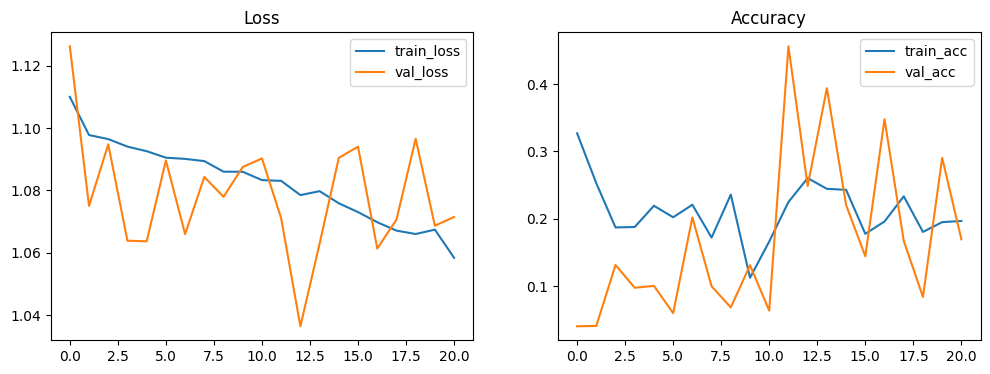

In [ ]:
# 15) Evaluation: plots
def plot_history(hist):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title("Accuracy")
    plt.show()

plot_history(history)

434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Classification report (test):
              precision    recall  f1-score   support

   downtrend       0.03      0.51      0.06       449
     neutral       0.94      0.19      0.31     13052
     uptrend       0.03      0.38      0.05       367

    accuracy                           0.20     13868
   macro avg       0.34      0.36      0.14     13868
weighted avg       0.89      0.20      0.30     13868



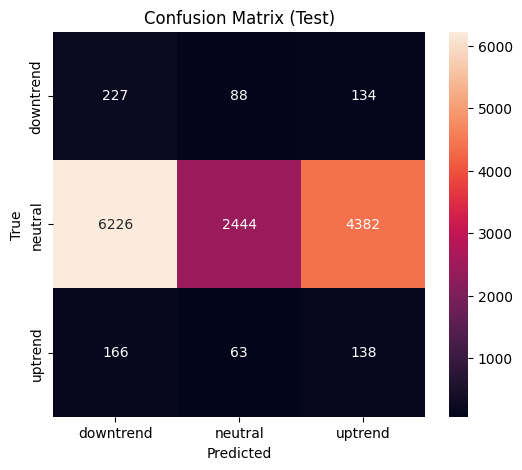

In [ ]:
# 16) Test evaluation
y_pred_probs = model.predict(X_test_s)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification report (test):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.show()

In [ ]:
# 18) Save model and encoder for later use
model.save("trend_classifier_lstm.h5")
import joblib
joblib.dump({"label_encoder": le, "scaler": scaler, "feature_cols": feature_cols}, "preprocessing_artifacts.joblib")

print("Artifacts saved: best_model.h5, trend_classifier_lstm.h5, preprocessing_artifacts.joblib")

Artifacts saved: best_model.h5, trend_classifier_lstm.h5, preprocessing_artifacts.joblib


In [42]:
!pip install --quiet mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.1 MB/s eta 0:00:00


In [47]:
import mplfinance as mpf

def plot_candles_with_trend(df, start_idx=0, window=60, lookahead=5, trend_label=None, predicted_label=None):
    """
    df: dataframe with OHLC and Date Time columns
    start_idx: index to start plotting
    window: number of past candles to show
    lookahead: number of future candles (to indicate trend start)
    trend_label: actual trend label (optional)
    predicted_label: predicted trend label (optional)
    """
    # Slice data
    end_idx = start_idx + window + lookahead
    plot_df = df.iloc[start_idx:end_idx].copy()
    plot_df.set_index('Date Time', inplace=True)

    # Add vertical line to indicate trend start
    vlines = [plot_df.index[window]]  # start of lookahead

    # Determine colors for vertical line
    color_actual = {'uptrend':'green','downtrend':'red','neutral':'blue'}.get(trend_label, 'gray')
    color_pred = {'uptrend':'lime','downtrend':'magenta','neutral':'cyan'}.get(predicted_label, None)

    vlines_dict = dict(vlines=vlines, colors=color_actual, linewidths=2, alpha=0.8)

    # If predicted_label exists, we can plot another vertical line slightly shifted
    if predicted_label:
        # shift by a small time delta to avoid overlap
        shifted_idx = plot_df.index[window] + pd.Timedelta(seconds=1)
        vlines_dict['vlines'] = [plot_df.index[window], shifted_idx]
        vlines_dict['colors'] = [color_actual, color_pred]

    mpf.plot(
        plot_df,
        type='candle',
        style='yahoo',
        title=f"Candles {start_idx} → {end_idx}\nActual: {trend_label} | Predicted: {predicted_label}",
        ylabel='Price',
        volume=True,
        vlines=vlines_dict
    )
